In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import random
import re
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from tqdm import tqdm
import torch
from transformers import LlamaTokenizer, LlamaForCausalLM
import pickle
import random
import json

random.seed(42)
np.random.seed(42)

device = "cuda:0"
STORAGE_DIR = "detectors/"

In [2]:
model = LlamaForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf",
                                         torch_dtype=torch.float16,
                                         output_attentions=True,
                                         device_map='auto'
                                        )
tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf",
                                           device_map='auto'
                                        )
device = "cuda:0"

/home/vozniuk/miniconda3/envs/llms/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
LAYER = 15
HEADS = [13, 15, 17]

In [37]:
def get_attentions(data, tokenizer, model, HEAD, LAYER, MAX_LEN=128): 
    encodinds_context_q = tokenizer(data, return_tensors="pt")
    device =next(iter(model.hf_device_map.values()))
    inputs = {
        "input_ids" : encodinds_context_q["input_ids"].to(device),
        "attention_mask" : encodinds_context_q["attention_mask"].to(device)
    }
    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions[HEAD][0,LAYER,:MAX_LEN,:MAX_LEN].detach().cpu().numpy()
    return attentions

def get_mean_and_columns(data, tokenizer, model, HEAD, LAYER, MAX_LEN=128): 
    encodinds_context_q = tokenizer(data, return_tensors="pt")
    device =next(iter(model.hf_device_map.values()))
    inputs = {
        "input_ids" : encodinds_context_q["input_ids"].to(device),
        "attention_mask" : encodinds_context_q["attention_mask"].to(device)
    }
    with torch.no_grad():
        outputs = model(**inputs)

    means = []
    columns = []
    for HEAD in HEADS:
        attentions = outputs.attentions[HEAD][0,LAYER,:MAX_LEN,:MAX_LEN].detach().cpu().numpy()
        human_columns = calc_top_three_column_values(attentions1)
        human_mean = calc_mean_attention_on_diagonal_for_hl(attentions1)
        means.append(human_mean)
        columns.append(human_columns)
        del attentions
        torch.cuda.empty_cache() 
    return np.array(means).mean(), np.array(columns).mean()


In [59]:
true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options) = do_calc_dev(halu_data, '', range(10000))

print("Train performace")
print("Train Halu 0-shot, no permutes")

best_head = print_results_train(true_labels, predicted_labels, next_token_labels)
save_results_train('halu-dialogue', '0', next_token_labels, logits_options, predicted_labels, predicted_raw, true_labels)

100%|█████████████████████████████████████| 10000/10000 [34:55<00:00,  4.77it/s]


Train performace
Train Halu 0-shot, no permutes
QK results 0.371 Best head:  22 5
Baseline score 0.2127


In [12]:
halu_prompt = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D\n"""

true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options) = do_calc_dev(halu_data, halu_prompt, range(10000))

print("Train performace")
print("Train Halu 1-shot, no permutes")

best_head = print_results_train(true_labels, predicted_labels, next_token_labels)
save_results_train('halu-dialogue', '1', next_token_labels, logits_options, predicted_labels, predicted_raw, true_labels)

100%|█████████████████████████████████████████████████████████████████| 10000/10000 [37:55<00:00,  4.39it/s]


Train performace
Train Halu 1-shot, no permutes
QK results 0.355 Best head:  15 8
Baseline score 0.2647


In [13]:
halu_prompt2 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A\n"""

true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options) = do_calc_dev(halu_data, halu_prompt2, range(10000))

print("Train performace")
print("Train Halu 2-shot, no permutes")

best_head = print_results_train(true_labels, predicted_labels, next_token_labels)
save_results_train('halu-dialogue', '2', next_token_labels, logits_options, predicted_labels, predicted_raw, true_labels)

100%|█████████████████████████████████████████████████████████████████| 10000/10000 [43:49<00:00,  3.80it/s]


Train performace
Train Halu 2-shot, no permutes
QK results 0.3401 Best head:  13 12
Baseline score 0.3071


In [60]:
halu_prompt2 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A
Context: [Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar.
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Snow Crash is similar to Zodiac.
B: The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.
C: The System of the world is similar one.
D: Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .
E: I don't know.
F: None of the above.
Answer: C\n"""

true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options) = do_calc_dev(halu_data, halu_prompt2, range(10000))

print("Train performace")
print("Train Halu 3-shot, no permutes")

best_head = print_results_train(true_labels, predicted_labels, next_token_labels)
save_results_train('halu-dialogue', '3', next_token_labels, logits_options, predicted_labels, predicted_raw, true_labels)

100%|█████████████████████████████████████| 10000/10000 [52:59<00:00,  3.14it/s]


Train performace
Train Halu 3-shot, no permutes
QK results 0.4061 Best head:  17 28
Baseline score 0.304


In [25]:
halu_prompt2 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A
Context: [Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar.
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Snow Crash is similar to Zodiac.
B: The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.
C: The System of the world is similar one.
D: Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .
E: I don't know.
F: None of the above.
Answer: C
Context: [Human]: I like Pulp Fiction. What do you think about it? [Assistant]: I love it. It was written by  Roger Avary [Human]: I heard he also wrote The Rules of Attraction. Do you know who is in that movie?
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Swoosie Kurtz is in it.
B: Fred Savage is in it.
C: Yes, it is a drama and crime fiction as well. Do you like crime fiction stories too?.
D: No, it was not made into a film. However, it was adapted into a popular Broadway musical.
E: I don't know.
F: None of the above.
Answer: B\n"""

true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options) = do_calc_dev(halu_data, halu_prompt2, range(10000))

print("Train performace")
print("Train Halu 4-shot, no permutes")

best_head = print_results_train(true_labels, predicted_labels, next_token_labels)
save_results_train('halu-dialogue', '4', next_token_labels, logits_options, predicted_labels, predicted_raw, true_labels)

100%|███████████████████████████████████| 10000/10000 [1:05:38<00:00,  2.54it/s]


Train performace
Train Halu 4-shot, no permutes
QK results 0.344 Best head:  13 12
Baseline score 0.2768


In [9]:
best_head = (14,24)

print("Eval performace")
print("Eval MMLU 0-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, '', range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 0-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [09:18<00:00, 17.02it/s]

QK results:  0.33621052631578946
Baseline score:  0.26673684210526316


In [10]:
prompt = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A\n"""

print("Eval performace")
print("Eval MMLU 1-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 1-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [10:41<00:00, 14.81it/s]

QK results:  0.39789473684210525
Baseline score:  0.3851578947368421


In [11]:
prompt2 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C\n"""

print("Eval performace")
print("Eval MMLU 2-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt2, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 2-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [12:16<00:00, 12.90it/s]

QK results:  0.38852631578947366
Baseline score:  0.41178947368421054


In [12]:
prompt3 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C
Question: Given that the sample has a standard deviation of zero, which of the following is a true statement?
Options:
A: The standard deviation of the population is also zero.
B: The sample mean and sample median are equal.
C: The sample may have outliers.
D: The population has a symmetric distribution.
E: I don't know.
F: None of the above.
Answer: B\n"""

print("Eval performace")
print("Eval MMLU 3-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt3, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 3-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [14:03<00:00, 11.27it/s]

QK results:  0.39842105263157895
Baseline score:  0.42694736842105263


In [13]:
prompt4 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C
Question: Given that the sample has a standard deviation of zero, which of the following is a true statement?
Options:
A: The standard deviation of the population is also zero.
B: The sample mean and sample median are equal.
C: The sample may have outliers.
D: The population has a symmetric distribution.
E: I don't know.
F: None of the above.
Answer: B
Question: The rate limiting enzyme of glycolysis is:?
Options:
A: phosphorylase.
B: hexokinase.
C: pyruvate dehydrogenase.
D: phosphofructokinase.
E: I don't know.
F: None of the above.
Answer: D\n"""

print("Eval performace")
print("Eval MMLU 4-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt4, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 4-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [16:06<00:00,  9.83it/s]

QK results:  0.41389473684210526
Baseline score:  0.4265263157894737


In [15]:
best_head = (14,24)

print("Eval performace")
print("Eval Halu_Dialogue 0-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(halu_data, best_head, '', range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval Halu_Dialogue 0-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [11:54<00:00, 13.29it/s]

QK results:  0.3058947368421053
Baseline score:  0.2114736842105263


In [16]:
prompt = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D\n"""

print("Eval performace")
print("Eval Halu_Dialogue 1-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(halu_data, best_head, prompt, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval Halu_Dialogue 1-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [18:37<00:00,  8.50it/s]

QK results:  0.3277894736842105
Baseline score:  0.2871578947368421


In [17]:
prompt2 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A\n"""


print("Eval performace")
print("Eval Halu_Dialogue 2-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(halu_data, best_head, prompt2, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval Halu_Dialogue 2-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [25:33<00:00,  6.20it/s]

QK results:  0.36273684210526314
Baseline score:  0.3256842105263158


In [18]:
prompt3 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A
Context: [Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar.
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Snow Crash is similar to Zodiac.
B: The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.
C: The System of the world is similar one.
D: Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .
E: I don't know.
F: None of the above.
Answer: C\n"""


print("Eval performace")
print("Eval Halu_Dialogue 3-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(halu_data, best_head, prompt3, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval Halu_Dialogue 3-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [32:50<00:00,  4.82it/s]

QK results:  0.3469473684210526
Baseline score:  0.30515789473684213


In [20]:
prompt4 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A
Context: [Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar.
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Snow Crash is similar to Zodiac.
B: The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.
C: The System of the world is similar one.
D: Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .
E: I don't know.
F: None of the above.
Answer: C
Context: [Human]: I like Pulp Fiction. What do you think about it? [Assistant]: I love it. It was written by  Roger Avary [Human]: I heard he also wrote The Rules of Attraction. Do you know who is in that movie?
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Swoosie Kurtz is in it.
B: Fred Savage is in it.
C: Yes, it is a drama and crime fiction as well. Do you like crime fiction stories too?.
D: No, it was not made into a film. However, it was adapted into a popular Broadway musical.
E: I don't know.
F: None of the above.
Answer: B\n"""


print("Eval performace")
print("Eval Halu_Dialogue 4-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(halu_data, best_head, prompt4, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)



Eval performace
Eval Halu_Dialogue 4-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [39:32<00:00,  4.00it/s]

QK results:  0.3466315789473684
Baseline score:  0.27978947368421053


In [10]:
best_head = (14,20)

print("Eval performace")
print("Eval MMLU 0-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, '', range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 0-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [09:56<00:00, 15.93it/s]

QK results:  0.3153684210526316
Baseline score:  0.26673684210526316


In [11]:
prompt = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A\n"""

print("Eval performace")
print("Eval MMLU 1-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 1-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [11:53<00:00, 13.31it/s]

QK results:  0.3396842105263158
Baseline score:  0.3851578947368421


In [12]:
prompt2 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C\n"""

print("Eval performace")
print("Eval MMLU 2-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt2, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 2-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [15:13<00:00, 10.40it/s]

QK results:  0.38726315789473686
Baseline score:  0.41178947368421054


In [13]:
prompt3 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C
Question: Given that the sample has a standard deviation of zero, which of the following is a true statement?
Options:
A: The standard deviation of the population is also zero.
B: The sample mean and sample median are equal.
C: The sample may have outliers.
D: The population has a symmetric distribution.
E: I don't know.
F: None of the above.
Answer: B\n"""

print("Eval performace")
print("Eval MMLU 3-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt3, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 3-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [16:56<00:00,  9.35it/s]

QK results:  0.3677894736842105
Baseline score:  0.42694736842105263


In [14]:
prompt4 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C
Question: Given that the sample has a standard deviation of zero, which of the following is a true statement?
Options:
A: The standard deviation of the population is also zero.
B: The sample mean and sample median are equal.
C: The sample may have outliers.
D: The population has a symmetric distribution.
E: I don't know.
F: None of the above.
Answer: B
Question: The rate limiting enzyme of glycolysis is:?
Options:
A: phosphorylase.
B: hexokinase.
C: pyruvate dehydrogenase.
D: phosphofructokinase.
E: I don't know.
F: None of the above.
Answer: D\n"""

print("Eval performace")
print("Eval MMLU 4-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt4, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 4-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [24:33<00:00,  6.45it/s]

QK results:  0.37705263157894736
Baseline score:  0.4265263157894737


In [15]:
best_head = (15,23)

print("Eval performace")
print("Eval MMLU 0-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, '', range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 0-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [09:56<00:00, 15.92it/s]

QK results:  0.2636842105263158
Baseline score:  0.26673684210526316


In [16]:
prompt = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A\n"""

print("Eval performace")
print("Eval MMLU 1-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 1-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [12:00<00:00, 13.19it/s]

QK results:  0.31484210526315787
Baseline score:  0.3851578947368421


In [17]:
prompt2 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C\n"""

print("Eval performace")
print("Eval MMLU 2-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt2, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 2-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [13:52<00:00, 11.42it/s]

QK results:  0.3443157894736842
Baseline score:  0.41178947368421054


In [18]:
prompt3 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C
Question: Given that the sample has a standard deviation of zero, which of the following is a true statement?
Options:
A: The standard deviation of the population is also zero.
B: The sample mean and sample median are equal.
C: The sample may have outliers.
D: The population has a symmetric distribution.
E: I don't know.
F: None of the above.
Answer: B\n"""

print("Eval performace")
print("Eval MMLU 3-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt3, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 3-shot, no permutes


100%|████████████████████████████████████████████████████████| 9500/9500 [16:00<00:00,  9.89it/s]

QK results:  0.33473684210526317
Baseline score:  0.42694736842105263


In [10]:
best_head = (15,23)


prompt4 = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A: serotonin.
B: dopamine.
C: acetylcholine.
D: thorazine.
E: I don't know.
F: None of the above.
Answer: A
Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
Options:
A: Duration recording.
B: Latency recording.
C: Event recording.
D: Whole-interval recording.
E: I don't know.
F: None of the above.
Answer: C
Question: Given that the sample has a standard deviation of zero, which of the following is a true statement?
Options:
A: The standard deviation of the population is also zero.
B: The sample mean and sample median are equal.
C: The sample may have outliers.
D: The population has a symmetric distribution.
E: I don't know.
F: None of the above.
Answer: B
Question: The rate limiting enzyme of glycolysis is:?
Options:
A: phosphorylase.
B: hexokinase.
C: pyruvate dehydrogenase.
D: phosphofructokinase.
E: I don't know.
F: None of the above.
Answer: D\n"""

print("Eval performace")
print("Eval MMLU 4-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, prompt4, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)

Eval performace
Eval MMLU 4-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [14:41<00:00, 10.78it/s]

QK results:  0.3352631578947368
Baseline score:  0.4265263157894737


In [12]:
best_head

(15, 23)

In [13]:
prompt4 = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Certainly. Undead and Unwed is very good.
B: No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C: Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D: yes and he also produced White Oleander and it was released in 1999.
E: I don't know.
F: None of the above.
Answer: D
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Okay, then you'll love Ferris Bueller's Day Off.
B: Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C: Okay, then you'll love The Lion King.
D: Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E: I don't know.
F: None of the above.
Answer: A
Context: [Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar.
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Snow Crash is similar to Zodiac.
B: The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.
C: The System of the world is similar one.
D: Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .
E: I don't know.
F: None of the above.
Answer: C
Context: [Human]: I like Pulp Fiction. What do you think about it? [Assistant]: I love it. It was written by  Roger Avary [Human]: I heard he also wrote The Rules of Attraction. Do you know who is in that movie?
Question: Which of the following responses is the most suitable one for the given dialogue?
Options: 
A: Swoosie Kurtz is in it.
B: Fred Savage is in it.
C: Yes, it is a drama and crime fiction as well. Do you like crime fiction stories too?.
D: No, it was not made into a film. However, it was adapted into a popular Broadway musical.
E: I don't know.
F: None of the above.
Answer: B\n"""


print("Eval performace")
print("Eval Halu_Dialogue 4-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(halu_data, best_head, prompt4, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)



Eval performace
Eval Halu_Dialogue 4-shot, no permutes


100%|███████████████████████████████████████| 9500/9500 [35:12<00:00,  4.50it/s]

QK results:  0.3953684210526316
Baseline score:  0.27978947368421053


In [61]:
import pickle

# Replace 'file.pckl' with the path to your .pckl file
with open('multichoice/mmlu-dialogue_10k_llama2_0-shot_train.pckl', 'rb') as file:
    mmlu_0 = pickle.load(file)

with open('multichoice/mmlu-dialogue_10k_llama2_1-shot_train.pckl', 'rb') as file:
    mmlu_1 = pickle.load(file)

with open('multichoice/mmlu-dialogue_10k_llama2_2-shot_train.pckl', 'rb') as file:
    mmlu_2 = pickle.load(file)

with open('multichoice/mmlu-dialogue_10k_llama2_3-shot_train.pckl', 'rb') as file:
    mmlu_3 = pickle.load(file)

with open('multichoice/mmlu-dialogue_10k_llama2_4-shot_train.pckl', 'rb') as file:
    mmlu_4 = pickle.load(file)

In [62]:
def calc_accuracy(dataset):
    
    qk_predicts = dataset['qk_predictions']
    true_labels = dataset['true_labels']

    mn = np.zeros((32,32))
    for i in range(32):
        for j in range(32):
            mn[i][j] = np.mean(qk_predicts[i][j] == true_labels)
            
    
    return mn

In [193]:
mmlu_0_accuracy = return_top_1_heads(calc_accuracy(mmlu_0))
mmlu_1_accuracy = return_top_1_heads(calc_accuracy(mmlu_1))
mmlu_2_accuracy = return_top_1_heads(calc_accuracy(mmlu_2))
mmlu_3_accuracy = return_top_1_heads(calc_accuracy(mmlu_3))
mmlu_4_accuracy = return_top_1_heads(calc_accuracy(mmlu_4))

In [194]:
intersection1 = list(set(mmlu_0_accuracy) & set(mmlu_1_accuracy))
print(intersection1)

[(14, 24), (15, 4), (17, 0), (14, 20), (20, 10), (18, 30)]


In [195]:
intersection2 = list(set(intersection1) & set(mmlu_2_accuracy))
print(intersection2)

[(14, 24), (15, 4), (17, 0), (14, 20), (20, 10), (18, 30)]


In [196]:
intersection3 = list(set(intersection2) & set(mmlu_3_accuracy))
print(intersection3)

[(14, 24), (15, 4), (17, 0), (14, 20), (20, 10), (18, 30)]


In [197]:
intersection4 = list(set(intersection3) & set(mmlu_4_accuracy))
print(intersection4)

[(14, 24), (15, 4), (17, 0), (14, 20), (20, 10), (18, 30)]


In [70]:
# Replace 'file.pckl' with the path to your .pckl file
with open('multichoice/halu-dialogue_10k_llama2_0-shot_train.pckl', 'rb') as file:
    halu_0 = pickle.load(file)

with open('multichoice/halu-dialogue_10k_llama2_1-shot_train.pckl', 'rb') as file:
    halu_1 = pickle.load(file)

with open('multichoice/halu-dialogue_10k_llama2_2-shot_train.pckl', 'rb') as file:
    halu_2 = pickle.load(file)

with open('multichoice/halu-dialogue_10k_llama2_3-shot_train.pckl', 'rb') as file:
    halu_3 = pickle.load(file)

with open('multichoice/halu-dialogue_10k_llama2_4-shot_train.pckl', 'rb') as file:
    halu_4 = pickle.load(file)

In [188]:
halu_0_accuracy = return_top_1_heads(calc_accuracy(halu_0))
halu_1_accuracy = return_top_1_heads(calc_accuracy(halu_1))
halu_2_accuracy = return_top_1_heads(calc_accuracy(halu_2))
halu_3_accuracy = return_top_1_heads(calc_accuracy(halu_3))
halu_4_accuracy = return_top_1_heads(calc_accuracy(halu_4))

In [189]:
intersection_halu_1 = list(set(halu_0_accuracy) & set(halu_1_accuracy))
print(intersection_halu_1)

[(14, 24), (14, 26), (27, 17), (14, 29), (15, 28)]


In [190]:
intersection_halu_2 = list(set(intersection_halu_1) & set(halu_2_accuracy))
print(intersection_halu_2)

[(14, 29), (14, 24), (15, 28), (14, 26)]


In [191]:
intersection_halu_3 = list(set(intersection_halu_2) & set(halu_3_accuracy))
print(intersection_halu_3)

[(14, 29), (14, 24), (15, 28), (14, 26)]


In [192]:
intersection_halu_4 = list(set(intersection_halu_3) & set(halu_4_accuracy))
print(intersection_halu_4)

[(14, 29), (14, 24), (14, 26)]


In [77]:
# Replace 'file.pckl' with the path to your .pckl file
with open('multichoice/hella-dialogue_10k_llama2_0-shot_train.pckl', 'rb') as file:
    hella_0 = pickle.load(file)

with open('multichoice/hella-dialogue_10k_llama2_1-shot_train.pckl', 'rb') as file:
    hella_1 = pickle.load(file)

with open('multichoice/hella-dialogue_10k_llama2_2-shot_train.pckl', 'rb') as file:
    hella_2 = pickle.load(file)

with open('multichoice/hella-dialogue_10k_llama2_3-shot_train.pckl', 'rb') as file:
    hella_3 = pickle.load(file)

with open('multichoice/hella-dialogue_10k_llama2_4-shot_train.pckl', 'rb') as file:
    hella_4 = pickle.load(file)

In [183]:
hella_0_accuracy = return_top_1_heads(calc_accuracy(hella_0))
hella_1_accuracy = return_top_1_heads(calc_accuracy(hella_1))
hella_2_accuracy = return_top_1_heads(calc_accuracy(hella_2))
hella_3_accuracy = return_top_1_heads(calc_accuracy(hella_3))
hella_4_accuracy = return_top_1_heads(calc_accuracy(hella_4))

In [184]:
intersection_hella_1 = list(set(hella_0_accuracy) & set(hella_1_accuracy))
print(intersection_hella_1)

[(15, 5), (15, 4), (18, 10), (14, 20), (14, 26), (17, 13), (14, 13), (13, 22)]


In [185]:
intersection_hella_2 = list(set(intersection_hella_1) & set(hella_2_accuracy))
print(intersection_hella_2)

[(15, 5), (15, 4), (18, 10), (14, 20), (14, 13), (13, 22)]


In [186]:
intersection_hella_3 = list(set(intersection_hella_2) & set(hella_3_accuracy))
print(intersection_hella_3)

[(15, 5), (15, 4), (18, 10), (14, 20), (14, 13), (13, 22)]


In [187]:
intersection_hella_4 = list(set(intersection_hella_3) & set(hella_4_accuracy))
print(intersection_hella_4)

[(15, 5), (15, 4), (18, 10), (14, 20), (14, 13), (13, 22)]


In [83]:
with open('multichoice/cosmos-dialogue_10k_llama2_0-shot_train.pckl', 'rb') as file:
    cosmos_0 = pickle.load(file)

with open('multichoice/cosmos-dialogue_10k_llama2_1-shot_train.pckl', 'rb') as file:
    cosmos_1 = pickle.load(file)

with open('multichoice/cosmos-dialogue_10k_llama2_2-shot_train.pckl', 'rb') as file:
    cosmos_2 = pickle.load(file)

with open('multichoice/cosmos-dialogue_10k_llama2_3-shot_train.pckl', 'rb') as file:
    cosmos_3 = pickle.load(file)

with open('multichoice/cosmos-dialogue_10k_llama2_4-shot_train.pckl', 'rb') as file:
    cosmos_4 = pickle.load(file)

In [178]:
cosmos_0_accuracy = return_top_1_heads(calc_accuracy(cosmos_0))
cosmos_1_accuracy = return_top_1_heads(calc_accuracy(cosmos_1))
cosmos_2_accuracy = return_top_1_heads(calc_accuracy(cosmos_2))
cosmos_3_accuracy = return_top_1_heads(calc_accuracy(cosmos_3))
cosmos_4_accuracy = return_top_1_heads(calc_accuracy(cosmos_4))

In [179]:
intersection_cosmos_1 = list(set(cosmos_0_accuracy) & set(cosmos_1_accuracy))
print(intersection_cosmos_1)

[(15, 5), (14, 24), (20, 8), (19, 4), (15, 4), (18, 10), (17, 0), (15, 23), (14, 20), (14, 26), (20, 10), (14, 13), (13, 22), (18, 30)]


In [180]:
intersection_cosmos_2 = list(set(intersection_cosmos_1) & set(cosmos_2_accuracy))
print(intersection_cosmos_2)

[(14, 24), (15, 5), (19, 4), (15, 4), (18, 10), (17, 0), (15, 23), (14, 20), (14, 26), (14, 13), (18, 30)]


In [181]:
intersection_cosmos_3 = list(set(intersection_cosmos_2) & set(cosmos_3_accuracy))
print(intersection_cosmos_3)

[(14, 24), (15, 5), (15, 4), (18, 10), (17, 0), (15, 23), (14, 20), (14, 26), (14, 13), (18, 30)]


In [182]:
intersection_cosmos_4 = list(set(intersection_cosmos_3) & set(cosmos_4_accuracy))
print(intersection_cosmos_4)

[(14, 24), (15, 5), (15, 4), (18, 10), (17, 0), (15, 23), (14, 20), (14, 26), (14, 13), (18, 30)]


In [199]:
list(set(intersection_cosmos_4) & set(intersection_hella_4) & set(intersection_halu_4) & set(intersection4))

[]

In [200]:
best_0_shot_heads = list(set(cosmos_0_accuracy) & set(mmlu_0_accuracy) & set(halu_0_accuracy) & set(hella_0_accuracy))
print(best_0_shot_heads)

[(14, 24)]


In [201]:
best_1_shot_heads = list(set(cosmos_1_accuracy) & set(mmlu_1_accuracy) & set(halu_1_accuracy) & set(hella_1_accuracy))
print(best_1_shot_heads)

[(15, 5), (15, 23), (14, 20)]


In [202]:
best_2_shot_heads = list(set(cosmos_2_accuracy) & set(mmlu_2_accuracy) & set(halu_2_accuracy) & set(hella_2_accuracy))
print(best_2_shot_heads)

[(14, 24), (15, 5), (15, 4), (18, 10), (15, 23), (16, 17)]


In [203]:
best_3_shot_heads = list(set(cosmos_3_accuracy) & set(mmlu_3_accuracy) & set(halu_3_accuracy) & set(hella_3_accuracy))
print(best_3_shot_heads)

[(14, 24), (15, 5), (15, 4), (18, 10), (15, 23), (14, 26), (17, 18)]


In [204]:
best_4_shot_heads = list(set(cosmos_4_accuracy) & set(mmlu_4_accuracy) & set(halu_4_accuracy) & set(hella_4_accuracy))
print(best_4_shot_heads)

[(14, 24), (15, 5), (14, 4), (15, 4), (18, 10), (15, 23), (14, 20), (14, 26), (17, 18), (16, 17)]


In [175]:
idx = 25
prompt = """Question: A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?
Options:
A. serotonin.
B. dopamine.
C. acetylcholine.
D. thorazine.
E. I don't know .
F. None of the above .
Answer: A\n"""
# Question: Which of the following types of data involves counting the number of occurrences of a behavior observed during a specified time period?
# Options:
# A. Duration recording.
# B. Latency recording.
# C. Event recording.
# D. Whole-interval recording.
# E. I don't know .
# F. None of the above .
# Answer: C\n"""
attentions = []
tokenizer_outputs = []
true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options), attentions1, tokenizer_output1 = do_calc_dev(data, "", range(idx, idx + 1))
attentions.append(attentions1[0][14][0,24,:,:])
tokenizer_outputs.append(tokenizer_output1[0])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


In [172]:
data[25]

{'source': 'MMLU',
 'task': 'QA',
 'subject': 'miscellaneous',
 'subcategory': 'other',
 'supcategory': 'other (business, health, misc.)',
 'question': "What singer appeared in the 1992 baseball film 'A League of Their Own'?",
 'choices': {'A': 'Brandy.',
  'B': 'Madonna.',
  'C': 'Garth Brooks.',
  'D': 'Whitney Houston.',
  'E': "I don't know.",
  'F': 'None of the above.'},
 'answer': 'B',
 'id': 25,
 'split': 'dev'}

In [182]:
tokenizer.decode(tokenizer_output1[0][24:32])

'Options:\n A. Brandy.'

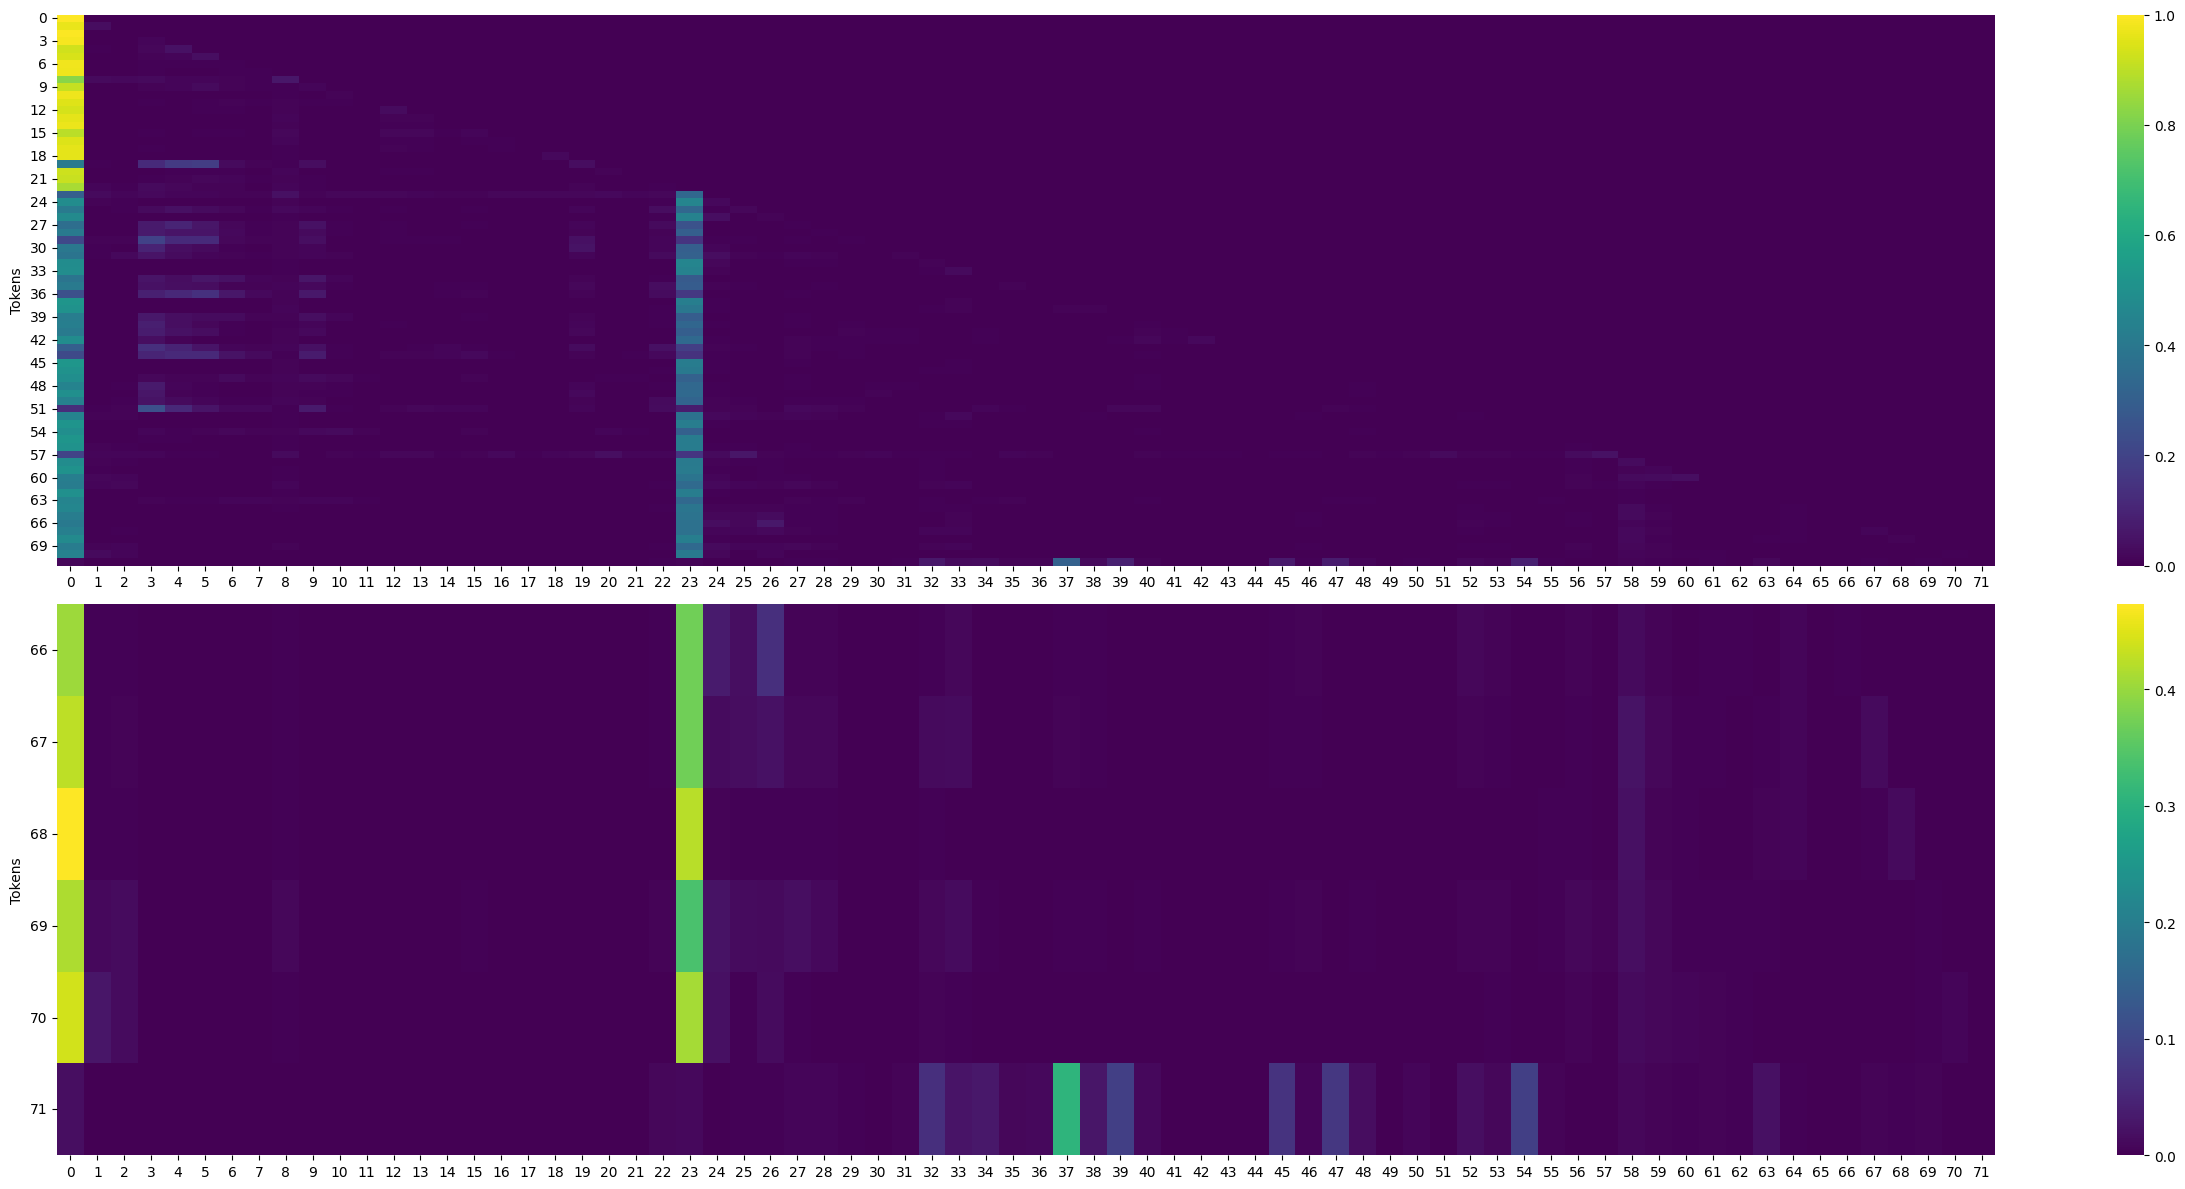

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(25, 12))
# idx = 25
# print(data[idx]['answer'])
# for i in range(30):
#     sns.heatmap(attentions[i].cpu(), ax=axs[i // 6, i % 6], cmap='viridis')
    # axs[i // 6, i % 6].set_title(f'Id {i + 30}')

axes0= sns.heatmap(attentions[0].cpu(), ax=axs[0], cmap='viridis')
axes = sns.heatmap(attentions[0][66:,:].cpu(), ax=axs[1], cmap='viridis')
# Adjust layout
axes0.set_ylabel('Tokens')
axes.set_ylabel('Tokens')
# axes.set_xlabel("""Question: What singer appeared in the 1992 baseball film 'A League of Their Own'?\\nOptions:\\nA. Brandy.\\nB. Madonna.\\nC. Garth Brooks.\\nD. Whitney Houston.\\nE. I don't know.\\nF. None of the above.\\nAnswer: B""", fontsize=13)
# a=axes.get_xticks().tolist()
# a[1]='A'
# axes.set_xticklabels(a)
axes.set_yticklabels([66, 67, 68, 69, 70, 71], rotation=360)
plt.tight_layout()
plt.savefig('last_layers_attention_14_24_mmlu_0_shot.png')
plt.show()

In [37]:
data_halu = []

with open('halu_dialogue_new.json') as json_data:
    data_halu = json.load(json_data)

print(len(data_halu))

true_labels_halu, (predicted_labels_halu, predicted_raw_halu), (next_token_labels_halu, logits_options_halu) = do_calc_dev(data_halu, '', range(500))

print("Train performace")
print("Train Halu 0-shot, no permutes")

best_head_halu = print_results_train(true_labels_halu, predicted_labels_halu, next_token_labels_halu)

10000


100%|█████████████████████████████████████████████████████████████| 500/500 [01:43<00:00,  4.85it/s]


Train performace
Train Halu 0-shot, no permutes
QK results 0.392 Best head:  22 5
Baseline score 0.236


In [131]:
data_halu[6]

{'source': 'Halu-OpenDialKG',
 'task': 'dialogue response selection',
 'knowledge': 'Neal Stephenson wrote ZodiacZodiac is written by Neal StephensonNeal Stephenson wrote The System of the World',
 'context': '[Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar. ',
 'question': 'Which of the following responses is the most suitable one for the given dialogue?',
 'choices': {'A': 'Snow Crash is similar to Zodiac.',
  'B': 'The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.',
  'C': 'The System of the world is similar one.',
  'D': 'Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .',
  'E': "I don't know.",
  'F': 'None of the above.'},
 'answer': 'C',
 'id': 6,
 'split': 'dev'}

In [132]:
idx = 25
prompt = """Context: [Human]: Could you recommend any books like The Secret Life of Bees? [Assistant]: Yes, its a great teen book, have you heard about A walk to remember ? It is also a great teen drama [Human]: I think I have.. is that one with Hunt Lowry? 
Question: Which of the following responses is the most suitable one for the given dialogue?
Options:
A. Certainly. Undead and Unwed is very good.
B. No, I don't think Hunt Lowry was involved in A Walk to Remember. However, he produced the movie adaptation of the popular novel, White Oleander, which was released in 1999.
C. Ty Olsen has been in lots of adventure type movies like X-Men 2, Walking Tall and RV. Have you seen any of those?.
D. yes and he also produced White Oleander and it was released in 1999.
E. I don't know .
F. None of the above .
Answer: D\n
Context: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it's a family film? [Human]: because it is funny
Question: Which of the following responses is the most suitable one for the given dialogue?
Options:
A. Okay, then you'll love Ferris Bueller's Day Off.
B. Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama?.
C. Okay, then you'll love The Lion King.
D. Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.
E. I don't know .
F. None of the above .
Answer: A\n
Context: [Human]: Could you recommend any good books by Neal Stephenson? [Assistant]: He Wrote Zodiac [Human]: Could you tell me about books similar to Zodiac? That book is vaguely familar.
Question: Which of the following responses is the most suitable one for the given dialogue?
Options:
A. Snow Crash is similar to Zodiac.
B. The Professor, A Tale, is a sequel to Jane Eyre. Interestingly, it was rejected many times before it was published in 1857!.
C. The System of the world is similar one.
D. Lou Romano provided his voice to the animated films Cars, The Incredibles and Ratatouille. .
E. I don't know .
F. None of the above .
Answer: C\n"""
# attentions_halu_0 = []
i = 32
true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options), attentions1, tokenizer_output1 = do_calc_dev(data_halu, prompt, range(i, i + 1))
attentions_halu_0.append(attentions1[0][14][0,24,:,:])

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


In [133]:
len(attentions_halu_0)

4

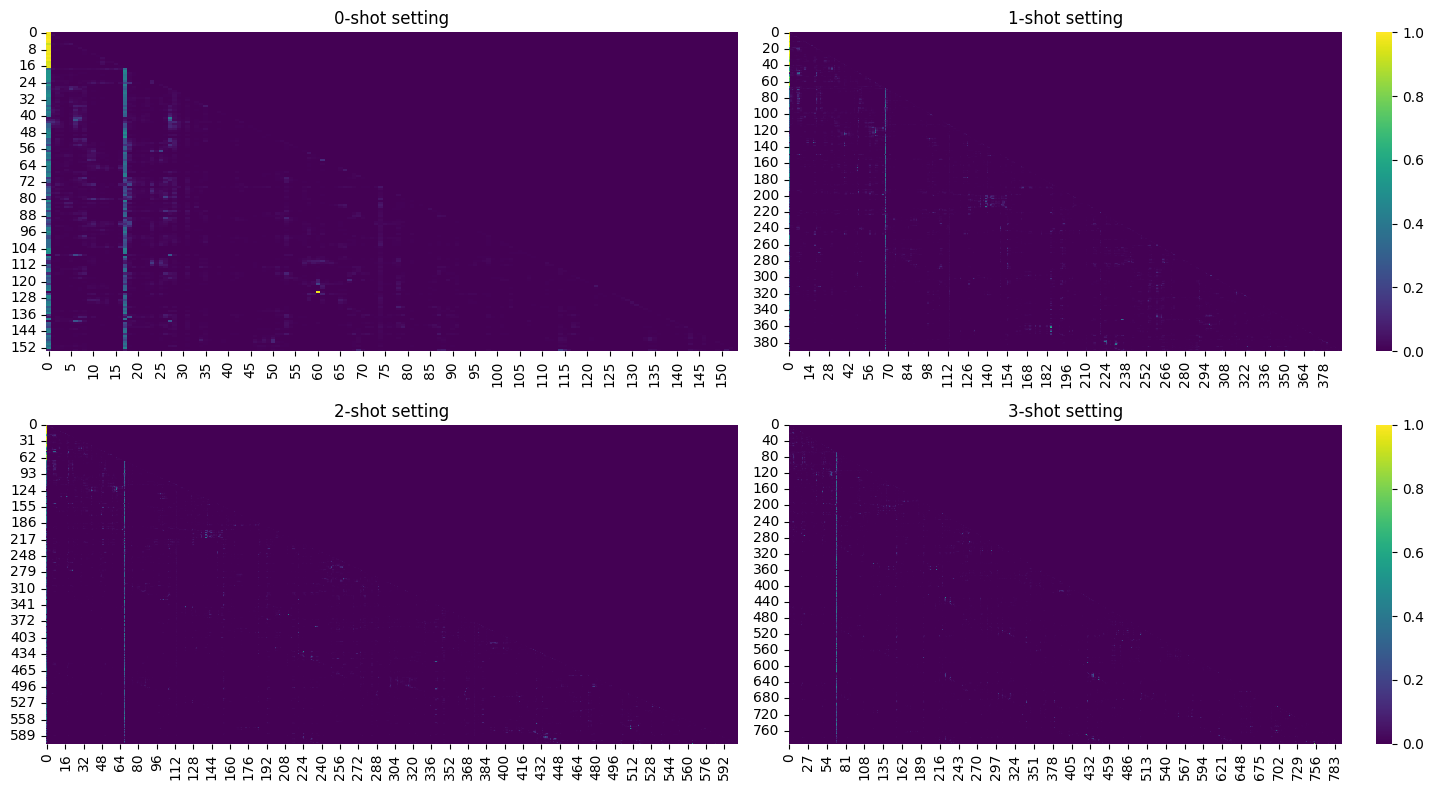

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
# idx = 25
# print(data[idx]['answer'])
for i in range(4):
    if i % 2 == 0:
        ax=sns.heatmap(attentions_halu_0[i].cpu(), ax=axs[i // 2, i % 2], cmap='viridis', cbar=False)
    else:
        ax=sns.heatmap(attentions_halu_0[i].cpu(), ax=axs[i // 2, i % 2], cmap='viridis', cbar=True)
    # ax.set_aspect("equal")
    axs[i // 2, i % 2].set_title(f'{i}-shot setting')


# plt.figure(figsize=(8, 5))
# ax = sns.heatmap(attentions1[0][14][0,24,:,:].cpu(), cmap='viridis')
# Adjust layout
# plt.ylabel('Tokens')
# plt.xlabel('Tokens')
plt.tight_layout()
plt.savefig('N-shot_attention_14_24_Halu.png')
plt.show()

In [43]:
data_hella = []

with open('hellaswag_10k_new.json') as json_data:
    data_hella = json.load(json_data)

print(len(data_hella))

true_labels_hella, (predicted_labels_hella, predicted_raw_hella), (next_token_labels_hella, logits_options_hella) = do_calc_dev(data_hella, '', range(500))

print("Train performace")
print("Train Hella 0-shot, no permutes")

best_head_halu = print_results_train(true_labels_hella, predicted_labels_hella, next_token_labels_hella)

10000


100%|█████████████████████████████████████████████████████████████| 500/500 [01:43<00:00,  4.85it/s]


Train performace
Train Hella 0-shot, no permutes
QK results 0.33 Best head:  15 5
Baseline score 0.268


In [46]:
data_cosmos = []

with open('cosmosqa_10k_new.json') as json_data:
    data_cosmos = json.load(json_data)

print(len(data_cosmos))

true_labels_cosmos, (predicted_labels_cosmos, predicted_raw_cosmos), (next_token_labels_cosmos, logits_options_cosmos) = do_calc_dev(data_cosmos, '', range(500))

print("Train performace")
print("Train Hella 0-shot, no permutes")

best_head_halu = print_results_train(true_labels_cosmos, predicted_labels_cosmos, next_token_labels_cosmos)

10000


100%|█████████████████████████████████████████████████████████████| 500/500 [01:38<00:00,  5.07it/s]


Train performace
Train Hella 0-shot, no permutes
QK results 0.422 Best head:  14 20
Baseline score 0.334


B


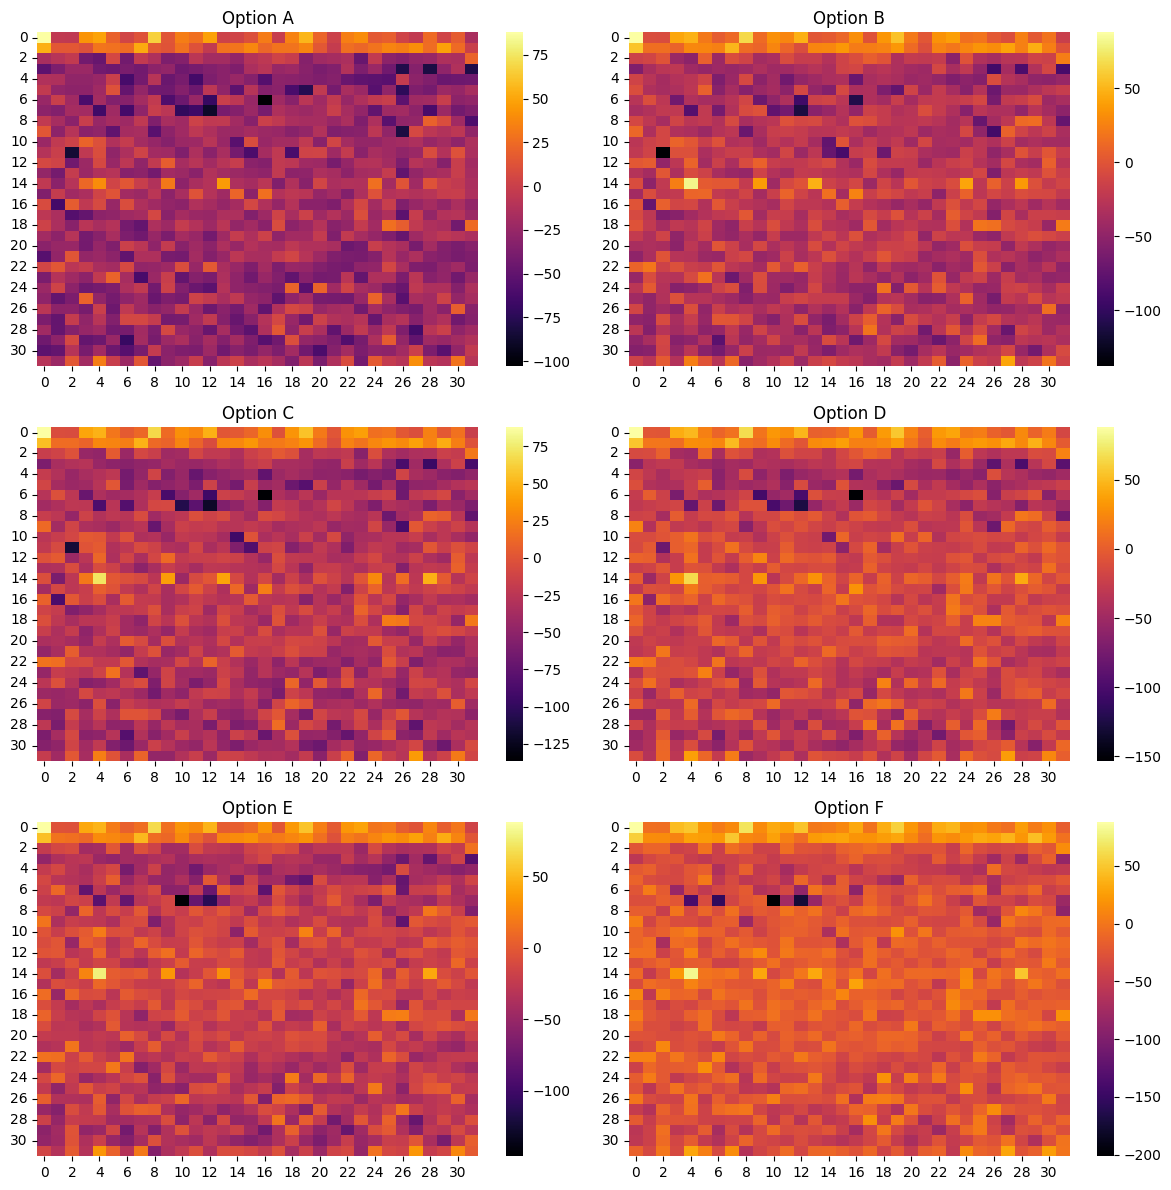

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# MMLU
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = 25
print(data[idx]['answer'])

sns.heatmap(predicted_raw[:,:,idx,0], ax=axs[0, 0], cmap='inferno')
axs[0, 0].set_title('Option A')

sns.heatmap(predicted_raw[:,:,idx,1], ax=axs[0, 1], cmap='inferno', cbar=True)
axs[0, 1].set_title('Option B')

sns.heatmap(predicted_raw[:,:,idx,2], ax=axs[1, 0], cmap='inferno')
axs[1, 0].set_title('Option C')

sns.heatmap(predicted_raw[:,:,idx,3], ax=axs[1, 1], cmap='inferno', cbar=True)
axs[1, 1].set_title('Option D')

sns.heatmap(predicted_raw[:,:,idx,4], ax=axs[2, 0], cmap='inferno', cbar=True)
axs[2, 0].set_title('Option E')

sns.heatmap(predicted_raw[:,:,idx,5], ax=axs[2, 1], cmap='inferno', cbar=True)
axs[2, 1].set_title('Option F')


# Adjust layout
plt.tight_layout()
plt.show()

B


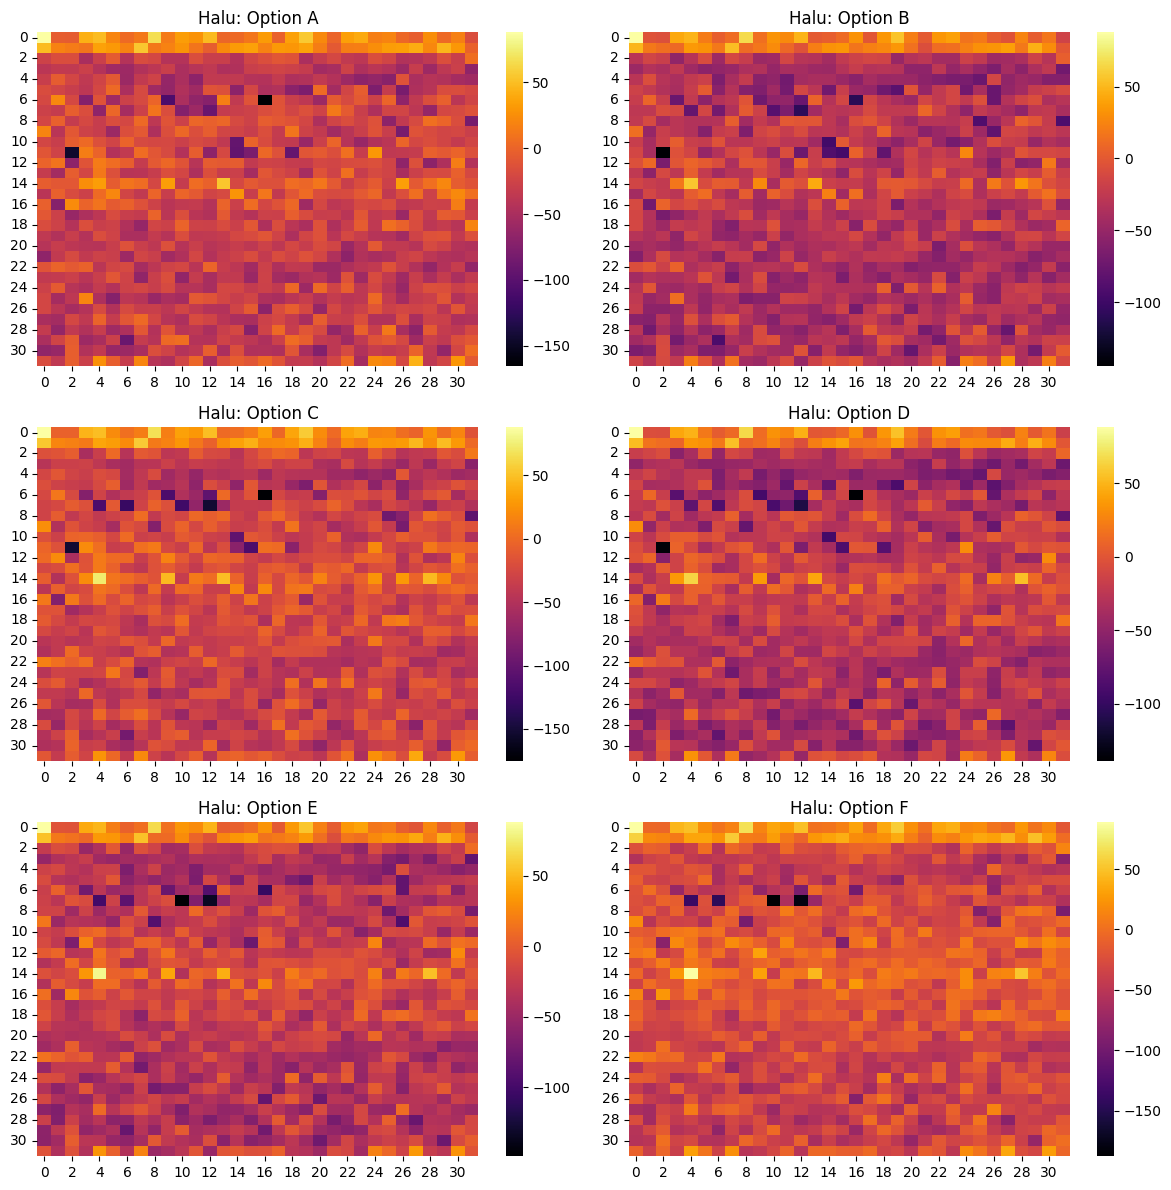

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Halu
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = 20
print(data[idx]['answer'])

sns.heatmap(predicted_raw_halu[:,:,idx,0], ax=axs[0, 0], cmap='inferno')
axs[0, 0].set_title('Halu: Option A')

sns.heatmap(predicted_raw_halu[:,:,idx,1], ax=axs[0, 1], cmap='inferno', cbar=True)
axs[0, 1].set_title('Halu: Option B')

sns.heatmap(predicted_raw_halu[:,:,idx,2], ax=axs[1, 0], cmap='inferno')
axs[1, 0].set_title('Halu: Option C')

sns.heatmap(predicted_raw_halu[:,:,idx,3], ax=axs[1, 1], cmap='inferno', cbar=True)
axs[1, 1].set_title('Halu: Option D')

sns.heatmap(predicted_raw_halu[:,:,idx,4], ax=axs[2, 0], cmap='inferno', cbar=True)
axs[2, 0].set_title('Halu: Option E')

sns.heatmap(predicted_raw_halu[:,:,idx,5], ax=axs[2, 1], cmap='inferno', cbar=True)
axs[2, 1].set_title('Halu: Option F')


# Adjust layout
plt.tight_layout()
plt.show()

A


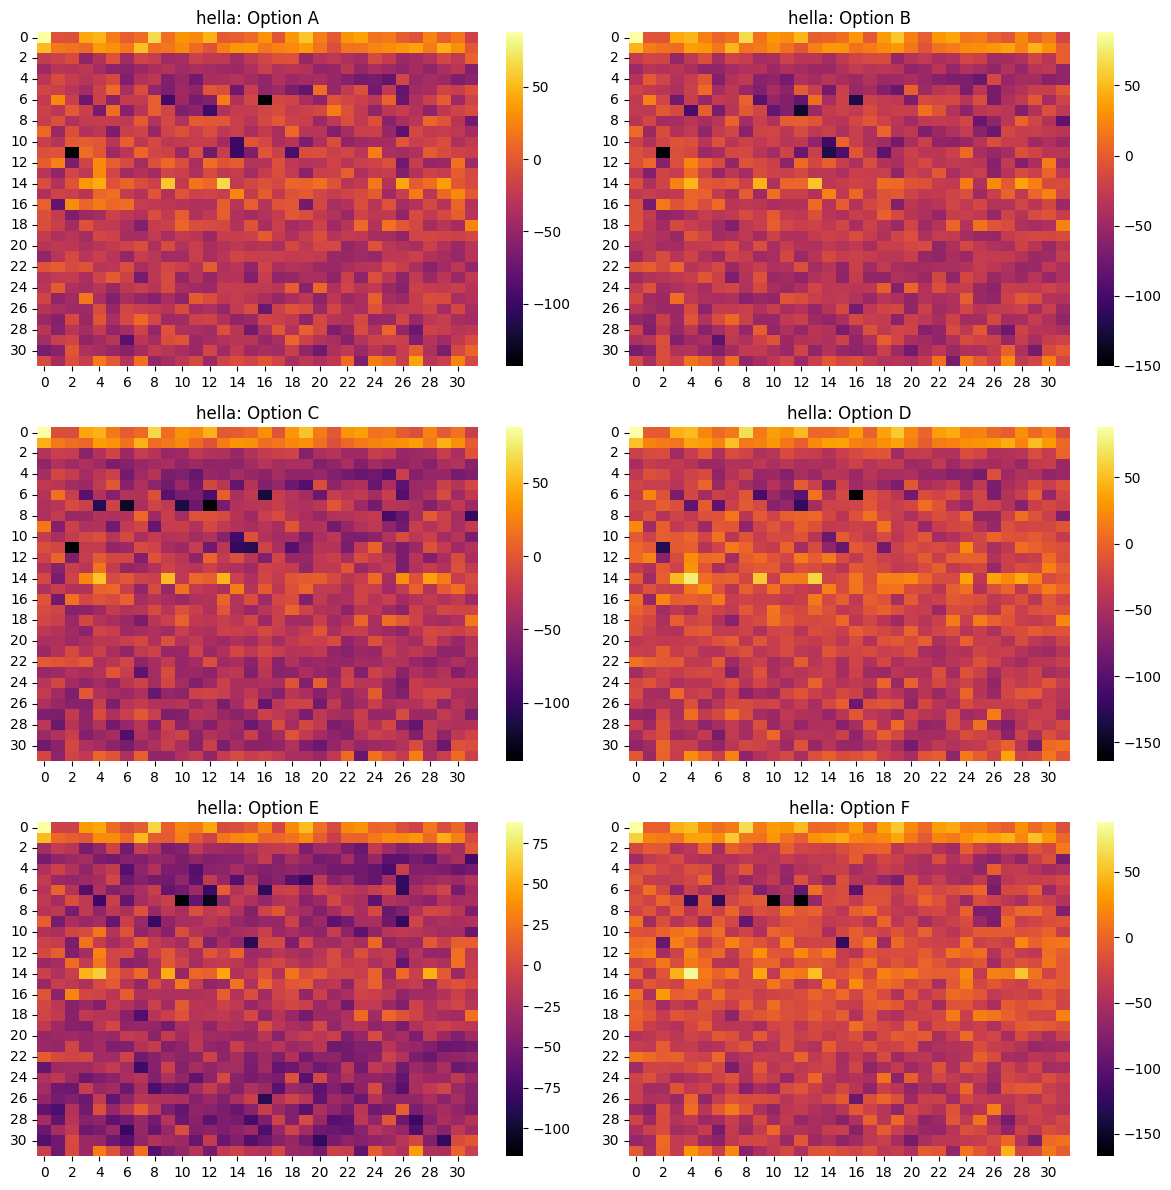

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Halu
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = 20
print(data_hella[idx]['answer'])

sns.heatmap(predicted_raw_hella[:,:,idx,0], ax=axs[0, 0], cmap='inferno')
axs[0, 0].set_title('hella: Option A')

sns.heatmap(predicted_raw_hella[:,:,idx,1], ax=axs[0, 1], cmap='inferno', cbar=True)
axs[0, 1].set_title('hella: Option B')

sns.heatmap(predicted_raw_hella[:,:,idx,2], ax=axs[1, 0], cmap='inferno')
axs[1, 0].set_title('hella: Option C')

sns.heatmap(predicted_raw_hella[:,:,idx,3], ax=axs[1, 1], cmap='inferno', cbar=True)
axs[1, 1].set_title('hella: Option D')

sns.heatmap(predicted_raw_hella[:,:,idx,4], ax=axs[2, 0], cmap='inferno', cbar=True)
axs[2, 0].set_title('hella: Option E')

sns.heatmap(predicted_raw_hella[:,:,idx,5], ax=axs[2, 1], cmap='inferno', cbar=True)
axs[2, 1].set_title('hella: Option F')


# Adjust layout
plt.tight_layout()
plt.show()

A


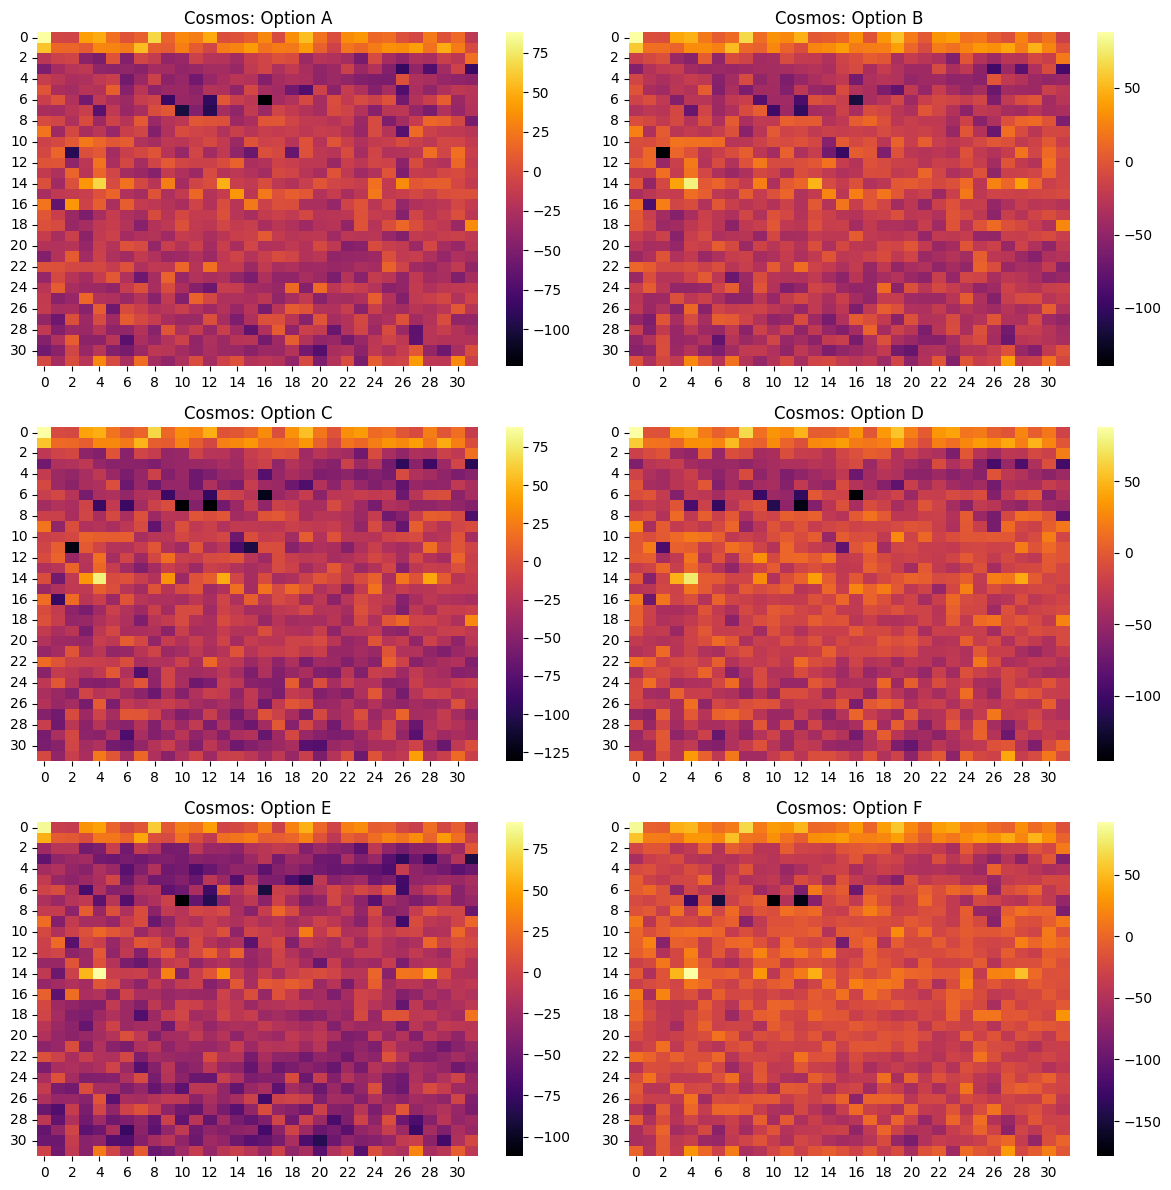

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Halu
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = 20
print(data_cosmos[idx]['answer'])

sns.heatmap(predicted_raw_cosmos[:,:,idx,0], ax=axs[0, 0], cmap='inferno')
axs[0, 0].set_title('Cosmos: Option A')

sns.heatmap(predicted_raw_cosmos[:,:,idx,1], ax=axs[0, 1], cmap='inferno', cbar=True)
axs[0, 1].set_title('Cosmos: Option B')

sns.heatmap(predicted_raw_cosmos[:,:,idx,2], ax=axs[1, 0], cmap='inferno')
axs[1, 0].set_title('Cosmos: Option C')

sns.heatmap(predicted_raw_cosmos[:,:,idx,3], ax=axs[1, 1], cmap='inferno', cbar=True)
axs[1, 1].set_title('Cosmos: Option D')

sns.heatmap(predicted_raw_cosmos[:,:,idx,4], ax=axs[2, 0], cmap='inferno', cbar=True)
axs[2, 0].set_title('Cosmos: Option E')

sns.heatmap(predicted_raw_cosmos[:,:,idx,5], ax=axs[2, 1], cmap='inferno', cbar=True)
axs[2, 1].set_title('Cosmos: Option F')


# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
import pickle

# Replace 'file.pckl' with the path to your .pckl file
with open('accuracies/MMLU_heads_train_acc_llama2.pckl', 'rb') as file:
    mmlu = pickle.load(file)

with open('accuracies/CosmosQA_heads_train_acc_llama2.pckl', 'rb') as file:
    cosmos = pickle.load(file)

with open('accuracies/Hellaswag_heads_train_acc_llama2.pckl', 'rb') as file:
    hella = pickle.load(file)

with open('accuracies/Halu_dialogue_heads_train_acc_llama2.pckl', 'rb') as file:
    halu = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(mmlu[0].shape)

(32, 32)


In [177]:
def return_top_1_heads(dataset):
    flattened_matrix = dataset.flatten()

    # Step 3: Calculate the number of top 5% elements
    top_5_percent_count = int(np.ceil(0.02 * flattened_matrix.size))
    
    # Step 4: Sort the flattened matrix in descending order
    sorted_indices = np.argsort(flattened_matrix)[::-1]
    
    # Step 5: Select the indices of the top 5% values
    top_5_percent_indices = sorted_indices[:top_5_percent_count]
    
    # Convert the flat indices back to 2D indices
    top_5_percent_2d_indices = np.unravel_index(top_5_percent_indices, dataset.shape)
    
    # Retrieve the top 5% values and their indices
    top_5_percent_values = flattened_matrix[top_5_percent_indices]
    top_5_percent_indices_2d = list(zip(top_5_percent_2d_indices[0], top_5_percent_2d_indices[1]))
    
    return top_5_percent_indices_2d

In [271]:
mmlu_heads = []
halu_heads = []
cosmos_heads = []
hella_heads = []
for i in range(0, 5):
    mmlu_heads.append(return_top_1_heads(mmlu, i))
    halu_heads.append(return_top_1_heads(halu, i))
    cosmos_heads.append(return_top_1_heads(cosmos, i))
    hella_heads.append(return_top_1_heads(hella, i))
heads = []
heads.extend(mmlu_heads)
heads.extend(halu_heads)
heads.extend(cosmos_heads)
heads.extend(hella_heads)

In [150]:
# top_0_shots = mmlu_heads[0] + halu_heads[0] + cosmos_heads[0] + hella_heads[0]
# top_1_shots = mmlu_heads[1] + halu_heads[1] + cosmos_heads[1] + hella_heads[1]
# top_2_shots = mmlu_heads[2] + halu_heads[2] +cosmos_heads[2] + hella_heads[2]
# top_3_shots = mmlu_heads[3] + halu_heads[3] + cosmos_heads[3] + hella_heads[3]
# top_4_shots = mmlu_heads[4] + halu_heads[4] + cosmos_heads[4] + hella_heads[4]

top_0_shots = hella_0_accuracy + mmlu_0_accuracy + cosmos_0_accuracy + halu_0_accuracy
top_1_shots = hella_1_accuracy + mmlu_1_accuracy + cosmos_1_accuracy + halu_1_accuracy
top_2_shots = hella_2_accuracy + mmlu_2_accuracy + cosmos_2_accuracy + halu_2_accuracy
top_3_shots = hella_3_accuracy + mmlu_3_accuracy + cosmos_3_accuracy + halu_3_accuracy
top_4_shots = hella_4_accuracy + mmlu_4_accuracy + cosmos_4_accuracy + halu_4_accuracy

In [154]:
intersection = list(set(top_0_shots) & set(top_1_shots))
intersection2 = list(set(top_2_shots) & set(intersection))
intersection3 = list(set(top_3_shots) & set(intersection2))
intersection4 = list(set(top_4_shots) & set(intersection3))


In [157]:
from collections import Counter
from matplotlib.patches import Rectangle
import seaborn as sns
# Sample arrays
# All arrays combined into a list of sets (to remove duplicates within the same array)
arrays = [intersection_cosmos_4, intersection_halu_4, intersection_hella_4, intersection4]

# Initialize a counter
element_counter = Counter()

# Iterate through each set and update the counter
for arr in arrays:
    for element in arr:
        element_counter[element] += 1

# Convert to a dictionary (optional)
result = dict(element_counter)

for k,v in result.items():
    if v <= 2:
        continue
    else:
        print(k ,v)

(20, 8) 3
(14, 13) 3
(15, 5) 3
(18, 10) 3
(14, 24) 4
(15, 4) 3
(13, 22) 3
(19, 4) 3
(14, 20) 4
(14, 26) 4
(17, 13) 3
(14, 29) 3
(16, 5) 3
(21, 1) 3


In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
def calc_heatmap(arrays):
    # Initialize a 32x32 grid to count occurrences
    grid_size = 32
    heatmap = np.zeros((grid_size, grid_size), dtype=int)

    # Iterate over the arrays
    for array in arrays:
        for (i, j) in array:
            if 0 <= i < grid_size and 0 <= j < grid_size:
                heatmap[i, j] += 1
    return heatmap
    # # Plotting the heatmap
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(heatmap, cmap='YlGnBu', cbar=True)
    # plt.title('Heatmap of Top 5% Heads')
    # plt.xlabel('Column Index')
    # plt.ylabel('Row Index')
    # plt.show()
    # plt.savefig('Heatmap_Top_5_Heads.png')

def draw_heatmap(arrays):
    # Initialize a 32x32 grid to count occurrences
    grid_size = 32
    heatmap = np.zeros((grid_size, grid_size), dtype=int)

    # Iterate over the arrays
    for array in arrays:
        for (i, j) in array:
            if 0 <= i < grid_size and 0 <= j < grid_size:
                heatmap[i, j] += 1
    # # Plotting the heatmap
    plt.figure(figsize=(18, 15))
    ax = sns.heatmap(heatmap, cmap='flare', cbar=True, linewidth=.5)
    colorbar = ax.collections[0].colorbar
    # The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
    r = colorbar.vmax - colorbar.vmin
    n = 5
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
    vmap = {0: 0, 1:1, 2:2, 3:3, 4:4}
    colorbar.set_ticklabels(list(vmap.values()))
    plt.xticks(fontsize=20 ,rotation=60)
    plt.yticks(fontsize=20 ,rotation=360)


# (19, 4) 3
    

    ax.add_patch(Rectangle((24, 14), 1, 1, fill=False, edgecolor='green', lw=4, label='top 5% for 4 datasets'))
    ax.add_patch(Rectangle((20, 14), 1, 1, fill=False, edgecolor='green', lw=4,  ))
    ax.add_patch(Rectangle((26, 14), 1, 1, fill=False, edgecolor='green', lw=4,  ))
    
    ax.add_patch(Rectangle((5, 15), 1, 1, fill=False, edgecolor='red', lw=4, label='top 5% for 3 datasets'))
    ax.add_patch(Rectangle((4, 15), 1, 1, fill=False, edgecolor='red', lw=4, ))
    ax.add_patch(Rectangle((29, 14), 1, 1, fill=False, edgecolor='red', lw=4,  ))
    ax.add_patch(Rectangle((13, 14), 1, 1, fill=False, edgecolor='red', lw=4, ))
    ax.add_patch(Rectangle((8, 20), 1, 1, fill=False, edgecolor='red', lw=4,  ))
    ax.add_patch(Rectangle((13, 17), 1, 1, fill=False, edgecolor='red', lw=4,  ))
    ax.add_patch(Rectangle((10, 18), 1, 1, fill=False, edgecolor='red', lw=4, ))
    ax.add_patch(Rectangle((4, 19), 1, 1, fill=False, edgecolor='red', lw=4, ))
    ax.add_patch(Rectangle((22, 13), 1, 1, fill=False, edgecolor='red', lw=4, ))
    ax.add_patch(Rectangle((1, 21), 1, 1, fill=False, edgecolor='red', lw=4, ))
    ax.add_patch(Rectangle((5, 16), 1, 1, fill=False, edgecolor='red', lw=4, ))
    
    # ax.add_patch(Rectangle((10, 18), 1, 1, fill=False, edgecolor='red', lw=3))
    # ax.add_patch(Rectangle((20, 14), 1, 1, fill=False, edgecolor='red', lw=3))
    # plt.title('Top 5% (Head, Layer) for intersected N-shots for 4 datasets')

    plt.xlabel('Head', fontsize=20)
    plt.ylabel('Layer', fontsize=20)
    plt.legend(fontsize=20, loc='upper right')
    plt.savefig('Heatmap_Top_1_Heads_On_Whole_Set.png')
    plt.show()

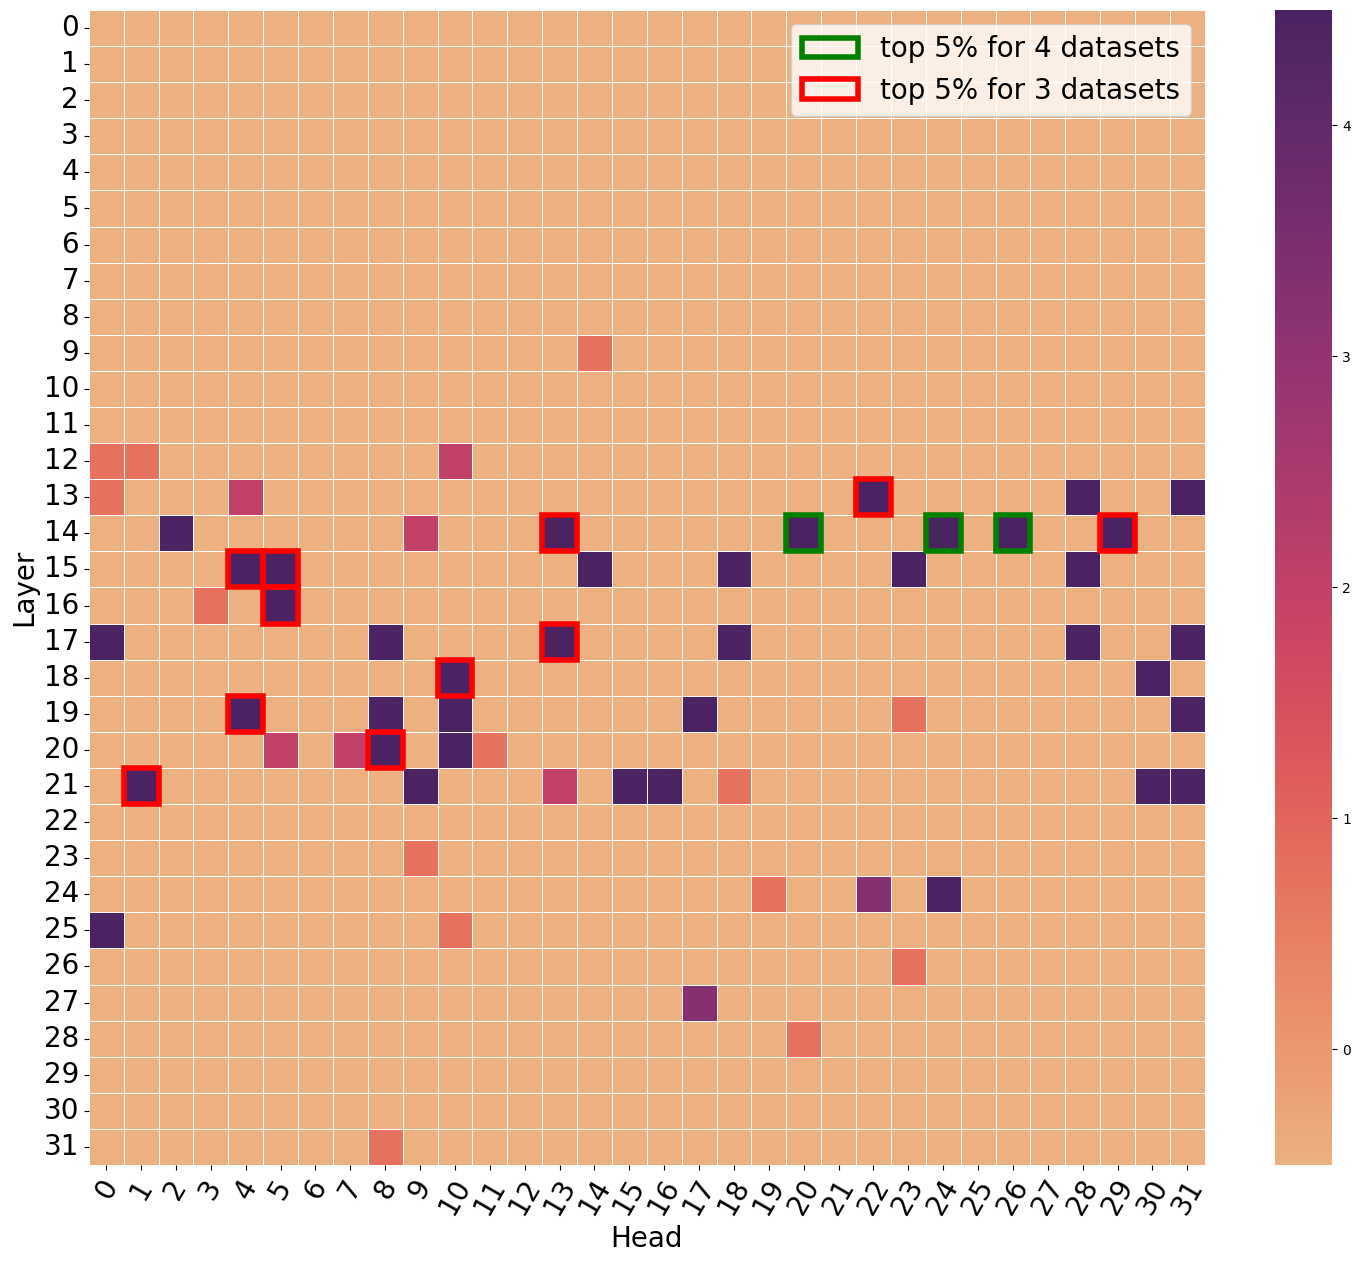

In [159]:
draw_heatmap([intersection, intersection2, intersection3, intersection4], )

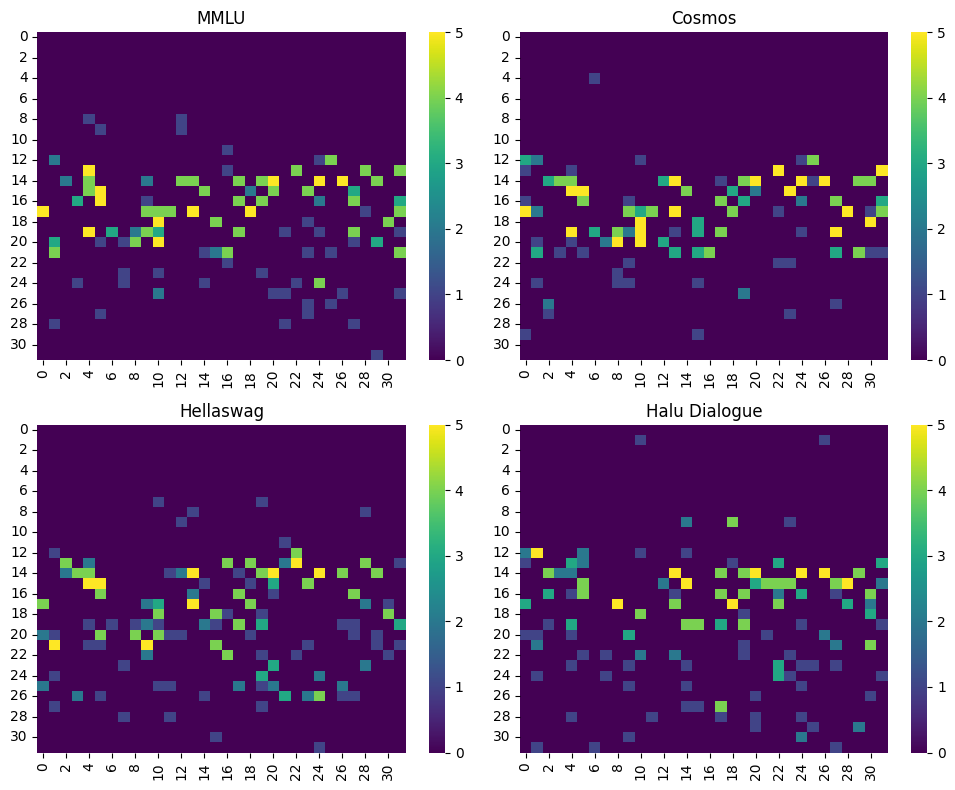

In [83]:
import matplotlib.pyplot as plt
import numpy as np


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(calc_heatmap(mmlu_heads), ax=axs[0, 0], cmap='viridis')
axs[0, 0].set_title('MMLU')

sns.heatmap(calc_heatmap(cosmos_heads), ax=axs[0, 1], cmap='viridis', cbar=True)
axs[0, 1].set_title('Cosmos')

sns.heatmap(calc_heatmap(hella_heads), ax=axs[1, 0], cmap='viridis')
axs[1, 0].set_title('Hellaswag')

sns.heatmap(calc_heatmap(halu_heads), ax=axs[1, 1], cmap='viridis', cbar=True)
axs[1, 1].set_title('Halu Dialogue')


# Adjust layout
plt.tight_layout()
plt.savefig('all_datasets_4_pics.png')
plt.show()

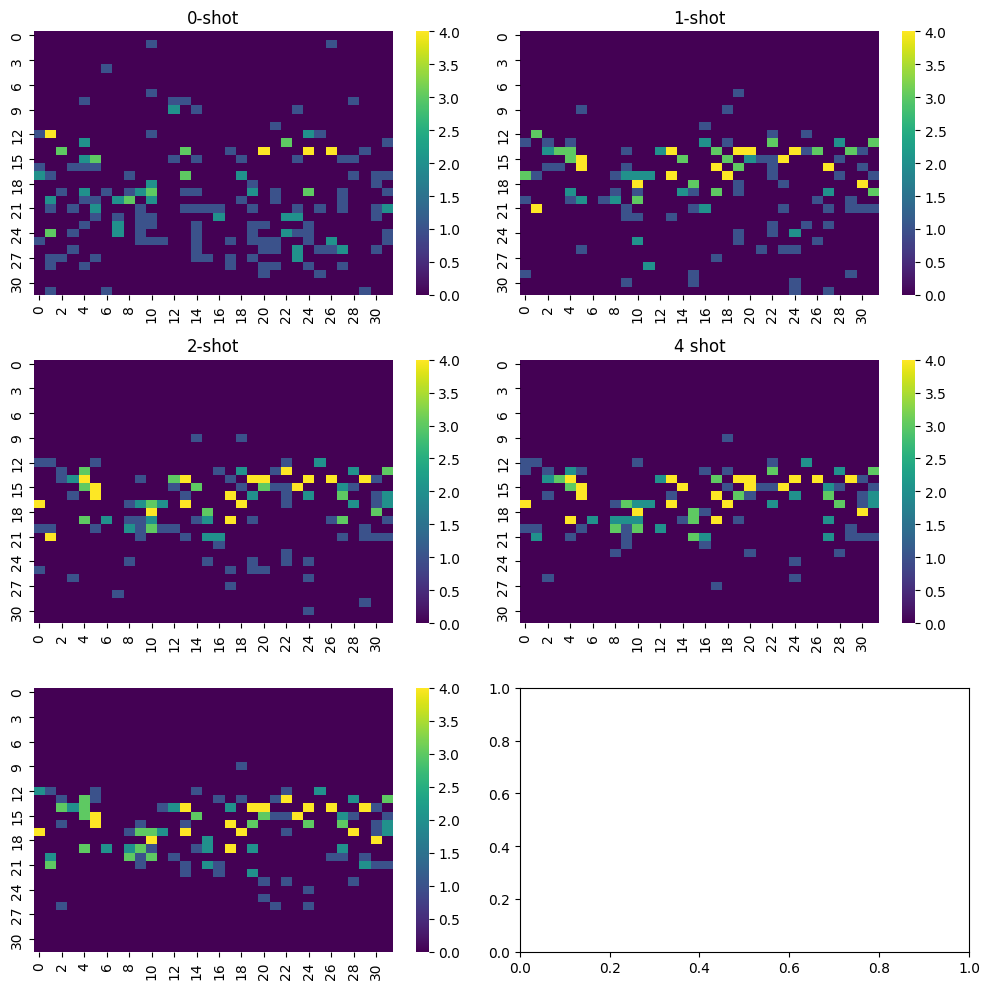

In [82]:
import matplotlib.pyplot as plt
import numpy as np


# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

sns.heatmap(calc_heatmap(top_0_shots), ax=axs[0, 0], cmap='viridis')
axs[0, 0].set_title('0-shot')

sns.heatmap(calc_heatmap(top_1_shots), ax=axs[0, 1], cmap='viridis', cbar=True)
axs[0, 1].set_title('1-shot')

sns.heatmap(calc_heatmap(top_2_shots), ax=axs[1, 0], cmap='viridis')
axs[1, 0].set_title('2-shot')

sns.heatmap(calc_heatmap(top_3_shots), ax=axs[1, 1], cmap='viridis', cbar=True)
axs[1, 1].set_title('3-shot')

sns.heatmap(calc_heatmap(top_4_shots), ax=axs[2, 0], cmap='viridis', cbar=True)
axs[1, 1].set_title('4 shot')


# Adjust layout
plt.tight_layout()
plt.savefig('all_shots_pics.png')
plt.show()

In [ ]:
mmlu_heads

In [30]:
flattened_matrix = hella[0].flatten()

# Step 3: Calculate the number of top 5% elements
top_5_percent_count = int(np.ceil(0.01 * flattened_matrix.size))

# Step 4: Sort the flattened matrix in descending order
sorted_indices = np.argsort(flattened_matrix)[::-1]

# Step 5: Select the indices of the top 5% values
top_5_percent_indices = sorted_indices[:top_5_percent_count]

# Convert the flat indices back to 2D indices
top_5_percent_2d_indices = np.unravel_index(top_5_percent_indices, data[0].shape)

# Retrieve the top 5% values and their indices
top_5_percent_values = flattened_matrix[top_5_percent_indices]
top_5_percent_indices_2d = list(zip(top_5_percent_2d_indices[0], top_5_percent_2d_indices[1]))

top_5_percent_indices_2d, top_5_percent_values

([(15, 5),
  (14, 13),
  (14, 2),
  (25, 17),
  (14, 24),
  (19, 8),
  (17, 13),
  (21, 1),
  (20, 8),
  (27, 1),
  (14, 20)],
 array([0.33 , 0.318, 0.316, 0.312, 0.312, 0.308, 0.308, 0.308, 0.306,
        0.306, 0.3  ]))

In [ ]:
promt_dialogue_1 = "Dialogue: [Human]: I like Home Alone could you give me recommendations based on this one [Human]: I need recommendations based on the movie Home Alone [Assistant]: Do you like it because it\'s a family film? [Human]: because it is funny \nQuestion: Which of the following responses is the most suitable one for the given dialogue?\nOptions:\nA. Okay, then you\'ll love Ferris Bueller\'s Day Off.\nB. Yes he did.  Sean Penn and Fiona Shaw were also in it.  Do you like drama? .\nC. Okay, then you\'ll love The Lion King.\nD. Two movies that Chris Weitz has directed are The Da Vinci Code and The Matrix. Martin Scorsese is a director similar to Chris Weitz. And The Golden Compass was edited by Steven Spielberg.\nE. I don\'t know .\nF. None of the above .\nAnswer: A\n"

true_labels, (predicted_labels, predicted_raw), (next_token_labels, logits_options) =\
                        do_calc_dev(data, promt_dialogue_1, range(500))

print("Train performace")
print("Halu_dialogue 1-shot, no permutes")

best_head = print_results_train(true_labels, predicted_labels, next_token_labels)
save_results_train('halu-dialogue', '1', next_token_labels, logits_options, predicted_labels, predicted_raw, true_labels)

print("Halu_dialogue 1-shot, A-D permutation")
true_labels2, (predicted_labels2, predicted_raw2), (next_token_labels2, logits_options2) =\
                    do_calc_dev(data, promt_dialogue_1, range(500), True)

best_head2 = print_results_train(true_labels2, predicted_labels2, next_token_labels2)
#save_results_train('halu-dialogue_shuffled', '1', next_token_labels2, logits_options2, predicted_labels2, predicted_raw2, true_labels2)

print("EVal performace")
print("Halu_dialogue 1-shot, no permutes")

true_labels, predicted_labels, next_token_labels = do_calc_eval(data, best_head, promt_dialogue_1, range(500, 10000))
print_results_test(true_labels, predicted_labels, next_token_labels)
save_results_test('halu-dialogue', '1', next_token_labels, predicted_labels, true_labels)

true_labels2, predicted_labels2, next_token_labels2 = do_calc_eval(data, best_head2, promt_dialogue_1, range(500, 10000), True)
print("Halu_dialogue 1-shot, A-D permutation")
print_results_test(true_labels2, predicted_labels2, next_token_labels2)
#save_results_test('halu-dialogue_shuffled', '1', next_token_labels2, predicted_labels2, true_labels2)

ours = compute_OUR_metric(true_labels, predicted_labels, true_labels2, predicted_labels2)
ours_baseline = compute_OUR_metric(true_labels, next_token_labels, true_labels2, next_token_labels2)

print("baseline: {:5.3f}%,   QK:  {:5.3f}%".format(100 * ours_baseline, ours*100))